# Projet Gustave Malachane Kilian Violet

In [ ]:
!py -m pip install requests
!py -m pip install pytest
!py -m pip install exifread

# Première partie : Récupération des données

Attention ici, si le fichier existe mais qu'il n'y a pas d'image, supprimer le fichier puis relancer le script

In [19]:
import urllib.request
import json
import pandas as pd
import requests
import shutil

# Partie téléchargement des images
def download_image(url, name):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        with open("./images/"+name+".jpg", "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code


# La requête qui récupère les données de wikidata et le traitement
url = "https://query.wikidata.org/sparql?query=Select%20%3Fvolcan%20%3Fimage%20%3Flabel_pays%20%3Fhauteur%20%3Flabel%20%7B%0A%20%20%3Fvolcan%20wdt%3AP31%20wd%3AQ169358%3B%0A%20%20%20%20%20%20%20%20wdt%3AP18%20%3Fimage%3B%0A%20%20%20%20%20%20%20%20wdt%3AP17%20%3Fpays%3B%0A%20%20%20%20%20%20%20%20wdt%3AP2660%20%3Fhauteur%3B%0A%20%20%20%20%20%20%20%20rdfs%3Alabel%20%3Flabel.%0A%20%20%0A%20%20%3Fpays%20rdfs%3Alabel%20%3Flabel_pays.%0A%20%20%0A%20%20FILTER(lang(%3Flabel)%3D%22en%22%20%26%26%20lang(%3Flabel_pays)%3D%22en%22)%0A%7D%0A%0ALIMIT%20150&format=json"
response = urllib.request.urlopen(url)
responsedata = json.loads(response.read().decode("utf-8"))

# Ici on instancie les variables qui serviront pour concevoir le fichier metadata 
array = []
metadata_list = []

# On boucle sur les données récupérées pour les inscrire dans le fichier (si le fichier existe pas)
try: 
    with open("metadata.json", "r", encoding="utf-8") as json_file:
        print("Le fichier existe déjà")
except FileNotFoundError:

    for data in responsedata["results"]["bindings"]:

            metadata = {
                "nom": data["label"]["value"],
                "hauteur": data["hauteur"]["value"],
                "pays": data["label_pays"]["value"]            
            }
        
    metadata_list.append(metadata)
    response = download_image(str(data["image"]["value"]).replace("%20", "_").replace("%C3%A1", "a"), metadata["nom"])

    dataframe = pd.DataFrame(array, columns=["label", "image"])
    print(dataframe)

    # Ecriture dans le fichier de metadata
    with open("metadata.json", "w", encoding="utf-8") as json_file:
        json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)
    


Le fichier existe déjà


## Récupération des données exifs des images

Ici grâce à la librairie PIL & exifread, nous pouvons accéder aux données exifs de l'image. elles sont ensuite stockées dans le fichier JSON metadata.json
On va aussi en profiter pour stocker des "tags" qu'on va définir grâce aux noms des volcans. On s'en servira plus tard pour analyser nos données 

In [ ]:
import os
import json
from PIL import Image
import exifread
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image


def get_dominant_colors(image_path, k=5):
    """ Extrait les k couleurs dominantes d'une image avec K-Means """
    with Image.open(image_path) as img:
        img = img.resize((100, 100))  # Réduire la taille pour accélérer le clustering
        img_array = np.array(img).reshape(-1, 3)  # Convertir en tableau de pixels

    # Clustering des couleurs
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(img_array)

    # Convertir les couleurs en hexadécimal
    colors = ['#%02x%02x%02x' % tuple(map(int, color)) for color in kmeans.cluster_centers_]
    return colors

# Dossier contenant les images
image_folder = "images"

# Parcourir chaque image
for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)

    try:
        # Ouvrir l'image avec PIL
        with Image.open(image_path) as img:
            width, height = img.size
            format_img = img.format

            colors = get_dominant_colors(image_path)

            # Déterminer l'orientation
            if width > height:
                orientation = "Paysage"
            elif height > width:
                orientation = "Portrait"
            else:
                orientation = "Carré"

        # Lire les métadonnées EXIF
        with open(image_path, "rb") as img_file:
            tags = exifread.process_file(img_file, details=False)
            date_creation = tags.get("EXIF DateTimeOriginal", 0000)
            camera_model = tags.get("Image Model", "Inconnu")

        # Stocker les métadonnées dans un dictionnaire (metadata_list n'a pas forcément récupéré de données à l'étape précédente)
        if len(metadata_list) <= 0:
            with open("metadata.json", 'r', encoding="utf-8") as f:
                metadata_list = json.load(f)

        metadataIndex = next((i for i, md in enumerate(metadata_list) if md["nom"]+".jpg" == image_name), -1)

        
        exif = {
            "nom": image_name,
            "chemin": image_path,
            "taille": f"{width}x{height}",
            "format": format_img,
            "orientation": orientation,
            "annee_capture": str(date_creation)[:4], # On a besoin que ça soit un entier pour la visualisation plus tard
            "date_creation": str(date_creation),
            "modele_camera": str(camera_model),
            "colors": colors,
        }

        tags = metadata_list[metadataIndex]["nom"].replace("-", " ").replace("_", " ").split()
        
        metadata_list[metadataIndex]["image"] = exif

        # On ne veut pas écraser les balises qui ont été ajoutées à la main
        if len(metadata_list[metadataIndex]["tags"]) <= 0:
            metadata_list[metadataIndex]["tags"] = tags

    except Exception as e:
        print(f"Erreur avec {image_name} : {e}")

# Sauvegarder les métadonnées en JSON
with open("metadata.json", "w", encoding="utf-8") as json_file:
    json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)

print("\n Métadonnées enregistrées dans metadata.json")


Erreur avec Mount Ragang.jpg : Image size (768777555 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.
Erreur avec Pico do Fogo.jpg : invalid literal for int() with base 10: ''

 Métadonnées enregistrées dans metadata.json


## Génération des utilisateurs

### QUESTION : Comment prévoyez-vous de traiter ces tags ? Est-il possible d'automatiser ce processus ?

On peut utiliser K-means pour analyser et regrouper les couleurs dominantes.
Ici les données présentes dans le fichier metadata.json proviennent essentiellement des exifs récupérée grâce à la librairie exifread.
Il y aussi une partie des données comme la hauteur, le pays, le nom de l'image et l'image en elle-même qui proviennent de Wikidata. 
Pour les autres tags, on peut demander aux utilisateurs de remplir les tags par images.

In [12]:
import json
import random

# Charger les éléments du json
with open("metadata.json", "r", encoding="utf-8") as f:
    volcans = json.load(f)

# Nombre de volcans
nombre_total_volcans = len(volcans)
print(f"Nombre total de volcans chargés : {nombre_total_volcans}")

pays_connus = ["États-Unis","France","Chine","Royaume-Uni","Allemagne","Inde","Japon","Brésil","Russie","Italie"]


# On génère des utilisateurs pour une simulation de consultation
utilisateurs = [
    {"id": i, "nom": f"Utilisateur_{i}", "volcans_consultés": []}
    for i in range(1, 51)
]

for utilisateur in utilisateurs:
    nb_volcans = random.randint(5, 20)
    age_utilisateur = random.randint(18, 70) 
    origine_utilisateur = random.randint(0, len(pays_connus)-1)
    volcans_choisis = random.sample(volcans, min(nb_volcans, nombre_total_volcans)) # Chaque utilisateur consulte entre 5 et 20 volcans choisi aléatoirement
    
    # Stocker uniquement le nom des volcans
    utilisateur["volcans_consultés"] = [volcan["nom"] for volcan in volcans_choisis]

    # Reste des infos utilisateur qui permettra de faire de meilleures analyses plus tard
    utilisateur["age"] = age_utilisateur
    utilisateur["origine"] = pays_connus[origine_utilisateur]

# Sauvegarde
with open("utilisateurs_volcans.json", "w", encoding="utf-8") as f:
    json.dump(utilisateurs, f, indent=4, ensure_ascii=False)

# Affichage d'un aperçu des 5 premiers utilisateurs
print(json.dumps(utilisateurs[:5], indent=4, ensure_ascii=False))  # Afficher les 5 premiers utilisateurs


Nombre total de volcans chargés : 128
[
    {
        "id": 1,
        "nom": "Utilisateur_1",
        "volcans_consultés": [
            "Cayambe",
            "Soufrière",
            "Mount Ragang",
            "Ampato",
            "Mount Douglas",
            "Imbabura Volcano",
            "Camiguin de Babuyanes",
            "Rinjani",
            "Calbuco",
            "Vulcano",
            "Semeru",
            "Kronotsky",
            "Mount Churchill",
            "Mount Balbi",
            "Mount Baker",
            "Mount Iliamna",
            "The Quill",
            "Volcán Tajumulco",
            "Licancabur"
        ],
        "age": 26,
        "origine": "France"
    },
    {
        "id": 2,
        "nom": "Utilisateur_2",
        "volcans_consultés": [
            "Daisen",
            "Volcán de la Deseada",
            "Kao",
            "Iztaccihuatl",
            "Mount Adams",
            "Mount Baker",
            "Ollagüe",
            "Tungurahua volcano"


## Partie analyse des données

In [ ]:
import json
import pytest
import collections
import matplotlib.pyplot as plt

def charger_donnees(fichier_volcans, fichier_utilisateurs):
    """Charge les données des volcans et des utilisateurs depuis les fichiers JSON."""
    with open(fichier_volcans, "r", encoding="utf-8") as f:
        volcans = json.load(f)

    with open(fichier_utilisateurs, "r", encoding="utf-8") as f:
        utilisateurs = json.load(f)

    return volcans, utilisateurs

def analyser_preferences(listes_volcans, utilisateurs):
    """Ici on va analyser les volcans déjà consultés par l'utilisateur pour ensuite définir leurs préférences"""

    # Analyse des volcans consultés
    for utilisateur in utilisateurs:

        # Initialisation des compteurs globaux
        global_colors = collections.Counter()
        global_orientations = collections.Counter()
        global_sizes = collections.Counter()
        global_countries = collections.Counter()
        global_tags = collections.Counter()

        volcans = utilisateur["volcans_consultés"]

        for nom_volcan in volcans:
            volcan_data = next((v for v in listes_volcans if v["nom"] == nom_volcan), None)
            if volcan_data:
                if "image" in volcan_data:
                    global_colors.update(volcan_data["image"]["colors"])
                    global_orientations[volcan_data["image"]["orientation"]] += 1

                    if "taille" in volcan_data["image"]:
                        largeur, _ = map(int, volcan_data["image"]["taille"].split("x"))
                        if largeur < 1000:
                            global_sizes["Petite"] += 1
                        elif largeur < 3000:
                            global_sizes["Moyenne"] += 1
                        else:
                            global_sizes["Grande"] += 1
                    
                    global_countries[volcan_data["pays"]] += 1
                
                if "tags" in volcan_data:
                    global_tags.update(volcan_data["tags"])


        """ On modifie l'utilisateur pour avoir ses préférences """
        utilisateur["preference"] = {
            "couleurs": global_colors.most_common(3),
            "orientation": global_orientations.most_common(1),
            "taille": global_sizes.most_common(1),
            "pays": global_countries.most_common(3),
            "tags": global_tags.most_common(3)
        }


    """ On note toutes les préférences dans le fichier """
    with open("utilisateurs_volcans.json", "w", encoding="utf-8") as f:
        json.dump(utilisateurs, f, indent=4, ensure_ascii=False)


    """ On retourne tous les utilisateurs mis à jour pour s'en servir pour la visualisation """
    return utilisateurs
    

volcans, utilisateurs = charger_donnees("metadata.json", "utilisateurs_volcans.json")    
utilisateurs = analyser_preferences(volcans, utilisateurs)


# Visualisation des données

Dans cette partie nous allons étudier toutes les données que nous avons récupérées grâce à des graphiques tracées avec la librairie matplotlib.
Ici il doit être possible d'avoir une visualisation globale mais aussi par utilisateur

In [ ]:
import matplotlib.pyplot as plot
import pandas as pd
from pandas import json_normalize
import json
import numpy
import math
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import scale, minmax_scale


# On charge le contenu du fichier
data = json.load(open("metadata.json", encoding="utf8"))

### Graphe proportion des volcans par pays

<Axes: title={'center': 'proportion de volcans par pays'}, xlabel='pays'>

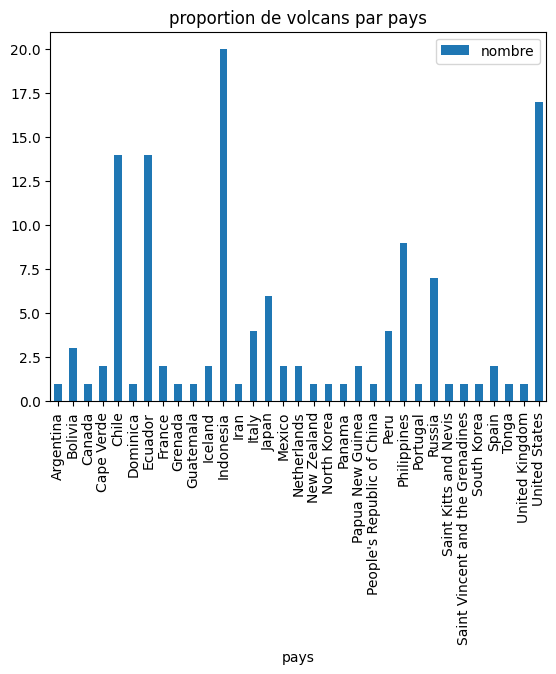

In [6]:
data_normalized = pd.DataFrame(json_normalize(data), columns=["pays", "nom"]).astype(
    dtype={"pays": "<U200", "nom": "<U200"}
)

grouped = data_normalized.groupby("pays").count()
grouped = grouped.rename(columns={"nom": "nombre"}).reset_index()
grouped.plot(x=0, kind="bar", title="proportion de volcans par pays")


# """
#     Le nombre d'images disponibles pour les différents types : taille de l'image, l'orientation des images, les modèles d'appareils photo, etc. 
# """

# array = []
# color_array = []
# for element in data:
#     if "image" in element:
#         if 'nom' in element["image"] and 'orientation' in element["image"] and 'taille' in element["image"] and 'modele_camera' in element["image"]: 
#             imageInfo = element["image"]
#             array.append({imageInfo["nom"], imageInfo["orientation"], imageInfo["taille"], imageInfo["modele_camera"]})
#             color_array.append(imageInfo["colors"])

# df = pd.DataFrame(array, columns=["nom", "orientation", "taille", "modele_camera"])
# df = df.astype(
#     dtype={"nom": "<U200", "orientation": "<U200", "taille": "<U200", "modele_camera": "U200"}
# )

# # TODO: Regrouper par tranche de valeur
# grouped_taille = df.groupby('taille').size()
# grouped_orientation = df.groupby('orientation').size()
# grouped_modele = df.groupby('modele_camera').size()

# (figure, axis) = plot.subplots(3,1, figsize=(30, 25))
# axis[0].bar(grouped_taille.index, grouped_taille.values)
# axis[1].bar(grouped_orientation.index, grouped_orientation.values)
# axis[2].bar(grouped_taille.index, grouped_taille.values)



# """ 
#     Caractéristique des couleurs

#     Chaque image a pour données ces 5 couleurs principales
#     On peut visualiser vers quelles teintes tendent les images que l'on possède

#     On peut visualiser de la manière suivante : 
#     Une courbe de valeur entre #000 et #FFF

# """

# image_RGB = []

# def hex_to_rgb(hex):
#     return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

# for image_colors in color_array:
#     for i,color in image_colors:
#         rgb_color = hex_to_rgb(color)
        


# cluster_count = 1

# count = df.groupby(["orientation", "modele_camera"]).count()

# clusters = KMeans()
# clusters.fit(count)

# unique, frequency = numpy.unique(clusters.labels_, return_counts=True)
# scaled_frequency = minmax_scale(frequency, feature_range=(50, 2000))

# # Diagramme de dispersion 3D
# plot.figure(figsize=(8, 8))
# axes = plot.axes(projection="3d")
# axes.scatter3D(
#     clusters.cluster_centers_[:, 0],
#     clusters.cluster_centers_[:, 1],
# )

# axes.set_xlabel("orientation")
# axes.set_xlabel("modele")
# axes.set_ylabel("count")


### Nombre d'image disponible pour chaque année 

<Axes: title={'center': "Nombre d'images par an"}, xlabel='image.annee_capture'>

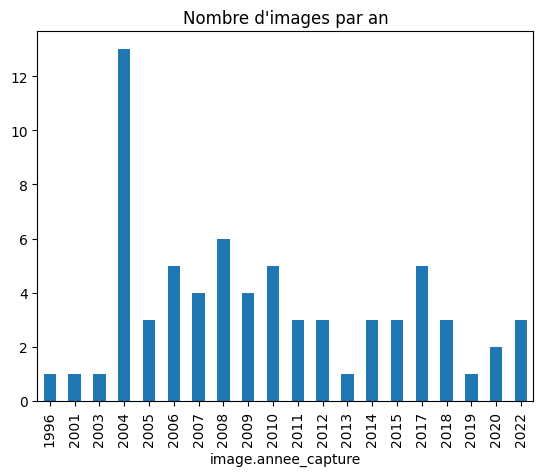

In [3]:
data2_normalized = pd.DataFrame(json_normalize(data, max_level=1), columns=["image.annee_capture", "nom"])
data2_normalized = data2_normalized.drop_duplicates(subset=["nom"], keep="first")

data2_normalized["image.annee_capture"] = pd.to_numeric(data2_normalized["image.annee_capture"], errors="coerce")
data2_normalized["image.annee_capture"] = data2_normalized["image.annee_capture"].fillna(data2_normalized["image.annee_capture"].median())

data2_normalized = data2_normalized.astype(
    dtype={"image.annee_capture": "<i4", "nom": "<U200"}
)

group_by_year = data2_normalized.groupby("image.annee_capture").size()

# Loc permet d'éliminer l'année 0 (le premier index)
filtered_year = group_by_year.loc[group_by_year.index > 0]
filtered_year.plot(x=0, kind="bar", title="Nombre d'images par an")

### Nombre d'image par propriétés

In [ ]:
def plot_data(title, data, color="skyblue"):
    """Affiche un graphique en barres des images par catégorie."""
    if not data:
        print(f"Aucune donnée pour {title}")
        return
    
    labels, values = zip(*data)
    plt.bar(labels, values, color=color)
    plt.title(title)
    plt.xlabel("Catégories")
    plt.ylabel("Fréquence")
    plt.show()

def generer_rapport(fichier_volcans, fichier_utilisateurs):

    # data contient les mds sur les volcans (début de la partie visualisation)
    
    md_images = []
    for volcan in data:
        if volcan["image"]:
            md_images.append(volcan["image"])
    
    if len(md_images) > 0:
        orientation = pd.DataFrame(json_normalize(data, max_level=1), columns=["orientation", "nom"])

        taille = []
        for image in md_images:
            if "taille" in image:
                largeur, _ = map(int, image["taille"].split("x"))
                if largeur < 1000:
                    taille["Petite"] += 1
                elif largeur < 3000:
                    taille["Moyenne"] += 1
                else:
                    taille["Grande"] += 1
    
    

    """Génère un rapport d'analyse des préférences des utilisateurs avec affichage de graphiques."""
    volcans, utilisateurs = charger_donnees(fichier_volcans, fichier_utilisateurs)
    
    utilisateurs = analyser_preferences(volcans, utilisateurs)
    
    top_3 = analyser_preferences(volcans, utilisateurs)

    print("🔹 Top 3 Couleurs:", top_3["couleurs"])
    print("🔹 Top 3 Orientations:", top_3["orientations"])
    print("🔹 Top 3 Tailles d'image:", top_3["tailles"])
    print("🔹 Top 3 Pays:", top_3["pays"])
    print("🔹 Top 3 Balises:", top_3["balises"])

    # Affichage des graphiques
    plot_data("Top 3 Couleurs Préférées", top_3["couleurs"], color="lightcoral")
    plot_data("Top 3 Orientations Préférées", top_3["orientations"], color="gold")
    plot_data("Top 3 Tailles d'Images Préférées", top_3["tailles"], color="lightgreen")
    plot_data("Top 3 Pays Préférés", top_3["pays"], color="dodgerblue")
    plot_data("Top 3 Balises Préférées", top_3["balises"], color="purple")



In [ ]:


# Données fictives pour les tests
volcans_test = [
    {"nom": "Etna", "pays": "Italie", "image": {"colors": ["#FF0000", "#000000"], "orientation": "Paysage", "taille": "1200x800"}},
    {"nom": "Vesuvius", "pays": "Italie", "image": {"colors": ["#AC0000", "#FF0000"], "orientation": "Portrait", "taille": "900x1600"}},
    {"nom": "Mayon", "pays": "Philippines", "image": {"colors": ["#AA0000", "#550000"], "orientation": "Paysage", "taille": "3000x2000"}},
]

utilisateurs_test = [
    {"id": 1, "volcans_consultés": ["Etna", "Vesuvius", "Mayon"]},
    {"id": 2, "volcans_consultés": ["Etna", "Mayon"]},
]

def test_analyse_preferences():
    """Vérifie que la fonction retourne bien un dictionnaire avec des listes de 3 éléments max."""
    result = analyser_preferences(volcans_test, utilisateurs_test)
    
    assert isinstance(result, dict), "Le résultat doit être un dictionnaire"
    assert all(isinstance(result[key], list) for key in result), "Chaque valeur du dictionnaire doit être une liste"
    
    for key in result:
        assert len(result[key]) <= 3, f"Le top 3 {key} ne doit pas contenir plus de 3 éléments"

def test_couleurs_dominantes():
    """Vérifie que les couleurs les plus fréquentes apparaissent en premier."""
    result = analyser_preferences(volcans_test, utilisateurs_test)
    top_colors = result["couleurs"]
    print(result["couleurs"])
    assert top_colors[0][0] == "#FF0000", "La couleur dominante devrait être #FF0000"
    assert top_colors[1][0] == "#AA0000", "La deuxième couleur devrait être #AA0000"

def test_pays_populaires():
    """Vérifie que l'Italie est bien le pays le plus populaire."""
    result = analyser_preferences(volcans_test, utilisateurs_test)
    top_pays = result["pays"]
    print(result["pays"])
    assert top_pays[0][0] == "Italie", "L'Italie devrait être le pays le plus populaire"

def test_tailles_dimages():
    """Vérifie que les tailles d'images sont bien catégorisées."""
    result = analyser_preferences(volcans_test, utilisateurs_test)
    top_tailles = dict(result["tailles"])
    print(result["tailles"])

    assert top_tailles["Moyenne"] > 0, "Il devrait y avoir au moins une image de taille moyenne"
    assert top_tailles["Petite"] > 0, "Il devrait y avoir au moins une image de petite taille"
    assert top_tailles["Grande"] > 0, "Il devrait y avoir au moins une image de grande taille"

test_analyse_preferences()
test_couleurs_dominantes()
test_pays_populaires()
test_tailles_dimages()


[('#AA0000', 3), ('#FF0000', 3), ('#550000', 2)]


AssertionError: La couleur dominante devrait être #FF0000

In [26]:
import json
import pytest
import collections
import pandas as pd

# Charger les données des volcans et des utilisateurs
with open("metadata.json", "r", encoding="utf-8") as f:
    volcans = json.load(f)

with open("utilisateurs_volcans.json", "r", encoding="utf-8") as f:
    utilisateurs = json.load(f)

# Fonction pour recommander des volcans à un utilisateur
def recommander_volcans(utilisateur, volcans):
    # Comptage des préférences de l'utilisateur
    user_countries = collections.Counter()
    user_tags = collections.Counter()
    user_colors = collections.Counter()

    # Récupération des volcans consultés par l'utilisateur
    unique_volcans = set(utilisateur["volcans_consultés"])

    for nom_volcan in unique_volcans:
        volcan_data = next((v for v in volcans if v["nom"] == nom_volcan), None)
        if volcan_data:
            # Ajout du pays
            user_countries[volcan_data["pays"]] += 1
            # Ajout des balises
            mots_cles = volcan_data["nom"].replace("-", " ").replace("_", " ").split()
            
            user_tags.update(mots_cles)
            # Ajout des couleurs
            if "image" in volcan_data:
                user_colors.update(volcan_data["image"].get("colors", []))

    # Déterminer les préférences principales
    top_countries = [c[0] for c in user_countries.most_common(3)]
    top_tags = [t[0] for t in user_tags.most_common(3)]
    top_colors = [col[0] for col in user_colors.most_common(3)]

    # Création d'une liste de volcans avec un score
    recommandations = []

    for volcan in volcans:
        score = 0

        # Vérification du pays
        if volcan["pays"] in top_countries:
            score += 3
        
        # Vérification des balises
        volcans_tags = volcan["nom"].replace("-", " ").replace("_", " ").split()
        for tag in top_tags:
            if tag in volcans_tags:
                score += 2

        # Vérification des couleurs
        if "image" in volcan:
            for color in top_colors:
                if color in volcan["image"].get("colors", []):
                    score += 1

        # Ajouter à la liste des recommandations si le score est > 0
        if score > 0:
            recommandations.append({
                "volcan": volcan["nom"],
                "pays": volcan["pays"],
                "score": score
            })

    # Trier les volcans par score décroissant et prendre les 5 meilleurs
    recommandations = sorted(recommandations, key=lambda x: x["score"], reverse=True)[:5]

    return recommandations

# Générer les recommandations pour chaque utilisateur
recommandations_utilisateurs = {}

for utilisateur in utilisateurs:
    recommandations_utilisateurs[utilisateur["id"]] = recommander_volcans(utilisateur, volcans)

# Sauvegarder les recommandations dans un fichier JSON
with open("recommandations_utilisateurs.json", "w", encoding="utf-8") as f:
    json.dump(recommandations_utilisateurs, f, ensure_ascii=False, indent=4)

print("Les recommandations ont été sauvegardées dans 'recommandations_utilisateurs.json'.")


Les recommandations ont été sauvegardées dans 'recommandations_utilisateurs.json'.


In [40]:


# Données de test (volcans)
volcans_test = [
    {"nom": "Etna", "pays": "Italy", "image": {"colors": ["#ff0000", "#00ff00"]}},
    {"nom": "Vesuvius", "pays": "Italy", "image": {"colors": ["#ff0000", "#0000ff"]}},
    {"nom": "Mount Fuji", "pays": "Japan", "image": {"colors": ["#ff0000", "#ffff00"]}},
    {"nom": "Mayon", "pays": "Philippines", "image": {"colors": ["#00ff00", "#0000ff"]}},
    {"nom": "Krakatoa", "pays": "Indonesia", "image": {"colors": ["#ff0000", "#00ff00"]}}
]

# Données de test (utilisateurs)
utilisateur_test = {
    "id": 1,
    "volcans_consultés": ["Etna", "Vesuvius", "Mayon"]
}

def test_recommander_volcans():
    """Test que la fonction recommande bien des volcans en fonction des préférences."""
    
    recommandations = recommander_volcans(utilisateur_test, volcans_test)

    # Vérifier que la recommandation n'est pas vide
    assert len(recommandations) > 0, "❌ Aucune recommandation trouvée"

    # Vérifier qu'il n'y a pas de doublons dans les résultats
    noms_volcans = [rec["volcan"] for rec in recommandations]
    assert len(noms_volcans) == len(set(noms_volcans)), "❌ Des volcans sont recommandés plusieurs fois"

    # Vérifier que les scores sont triés par ordre décroissant
    scores = [rec["score"] for rec in recommandations]
    assert scores == sorted(scores, reverse=True), "❌ Les scores ne sont pas triés correctement"

    # Vérifier que les recommandations sont pertinentes (pays, balises, couleurs)
    volcans_recommandés = {rec["volcan"] for rec in recommandations}
    assert "Mount Fuji" in volcans_recommandés or "Krakatoa" in volcans_recommandés, "❌ Les recommandations ne sont pas pertinentes"

    print("✅ Test `recommander_volcans` passé avec succès !")

test_recommander_volcans()


✅ Test `recommander_volcans` passé avec succès !
